# Download Chl-a products of multiple sources and make regional plots

**Author:** Jiaxu Zhang (UW, NOAA, jiaxu.zhang@noaa.gov)

</div>

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

## Summary

This tutorial demonstrates how to download chlorophyll-a concentration products from various satellites and create regional plots at publication quality.

## Contents

1. [Download and process PACE OCI data](#1.-Download-and-process-PACE-OCI-data)
2. [Download and process SNPP VIIRS data](#2.-Download-and-process-SNPP-VIIRS-data)
3. [Download and process MODIS data](#3.-Download-and-process-MODIS-data)
4. [Combine the plots side by side](#4.-Combine-the-plots-side-by-side)


We begin by importing the packages used in this notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import earthaccess
import requests

import sys
sys.path.append("../scripts")
import PACEToolkit.regional_plot as regional_plot

## 1. Download and Process PACE OCI Data

[This tutorial](https://pacehackweek.github.io/pace-2024/presentations/hackweek/earthdata_cloud_access.html) demonstrates how to use the `earthaccess` package to create PACE OCI Chl-a plots without downloading a local copy. In this tutorial, we will use the `hypercoast` package to achieve the same goal.

You may need to install [hypercoast](https://github.com/opengeos/HyperCoast) in your environment (uncomment the following line).

In [2]:
# %pip install "hypercoast[extra]"
import hypercoast

In [15]:
# hypercoast.nasa_earth_login()

# Temporal range
temporal = ("2024-06-01", "2024-06-15")  
# results= hypercoast.search_pace_chla(temporal=temporal, 
#                                      bbox = bbox)
# hypercoast.download_nasa_data(results, "../data/pace_chla")

In [5]:
files = "../data/pace_chla/*nc"
array = hypercoast.read_pace_chla(files)
array

<xarray.DataArray 'chlor_a' (lat: 1800, lon: 3600, date: 15)> Size: 389MB
dask.array<transpose, shape=(1800, 3600, 15), dtype=float32, chunksize=(512, 1024, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon          (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date         (date) <U10 600B '2024-06-01' '2024-06-02' ... '2024-06-15'
    spatial_ref  int64 8B 0
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          lg(mg m^-3)
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    display_scale:  log
    display_min:    0.01
    display_max:    20.0
    date:           ['2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', ...

`hypercoast` has a plot function `viz_pace_chla` to easily take a quick view of the mean value of the period.

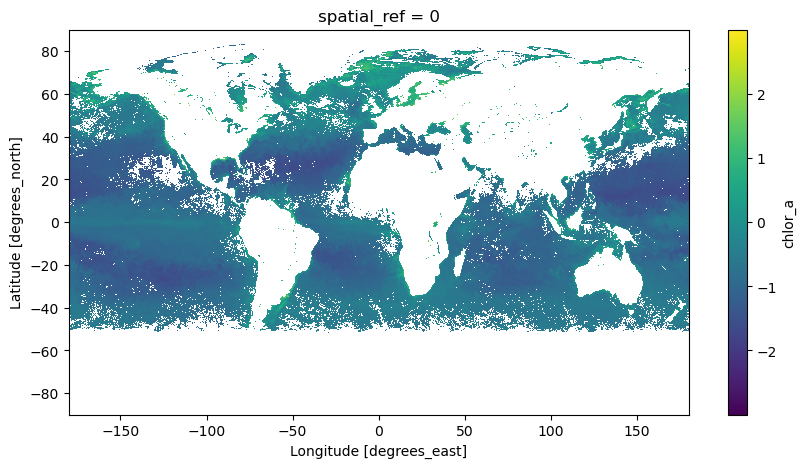

In [5]:
hypercoast.viz_pace_chla(array, cmap="viridis", size=5)

Custermize the dataset and subset it for plotting. First we calculate the mean of the 15-day data.

In [6]:
array_mean = array.mean('date')
array_mean.attrs.update(
    {
        "long_name": f'PACE {array.attrs["long_name"]}',
        "units": f'lg({array.attrs["units"]})',
    }
)

Define the boundary of the area and perform the reduction. Note that the latitude values descend in the index, so the slice will flip the values `lat_bnds = [max_lat, min_lat]`.

In [7]:
min_lon = -179     # lower left longitude
min_lat = 50       # lower left latitude
max_lon = -140     # upper right longitude
max_lat = 72       # upper right latitude

lon_bnds = [min_lon, max_lon]
lat_bnds = [max_lat, min_lat]
array_mean_clip = array_mean.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

In [8]:
array_mean_clip

<xarray.DataArray 'chlor_a' (lat: 220, lon: 390)> Size: 343kB
dask.array<getitem, shape=(220, 390), dtype=float32, chunksize=(220, 390), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 880B 71.95 71.85 71.75 ... 50.25 50.15 50.05
  * lon          (lon) float32 2kB -178.9 -178.9 -178.8 ... -140.2 -140.1 -140.1
    spatial_ref  int64 8B 0
Attributes:
    long_name:  PACE Chlorophyll Concentration, OCI Algorithm
    units:      lg(lg(mg m^-3))

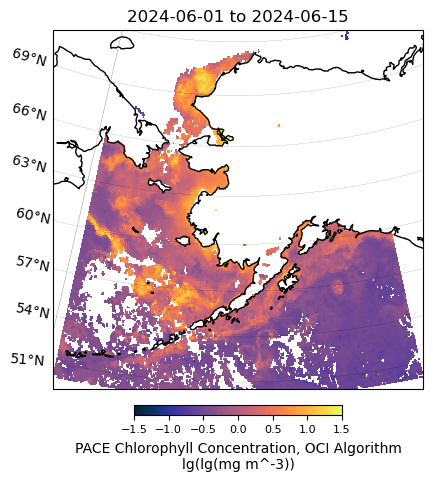

In [9]:
# Plot PACE data
m = regional_plot.plot_regional_map(array_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

[back to top](#Contents)

## 2. Download and process SNPP VIIRS data

There are many different ways to obtain L3 data (e.g., from https://oceancolor.gsfc.nasa.gov/l3/) \
Here we show how to get data from NOAA's ERDDAP server (https://oceanwatch.pifsc.noaa.gov/erddap/index.html)

In [16]:
### Uncomment the following lines if you need to download the data for the first time

# import urllib.request 
# url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/noaa_snpp_chla_daily.nc?chlor_a%5B(2024-06-01T12:00:00Z):1:(2024-06-15T12:00:00Z)%5D%5B(0.0):1:(0.0)%5D%5B(77.00625):1:(50.006249999999994)%5D%5B(180.01875):1:(221.98125000000002)%5D'
# urllib.request.urlretrieve(url, "../data/viirs.nc")

In [11]:
viirs_ds = xr.open_dataset('../data/viirs.nc')

Since the dataset is already subsetted for the area of interest, the next step is to compute the 15-day mean and create plots.

In [12]:
viirs_chla = np.log10(viirs_ds['chlor_a'])
# Calculate the temporal mean
viirs_chla_mean = viirs_chla.mean('time')

viirs_chla_mean.attrs.update(
    {
        "long_name": "SNPP VIIRS, L3 Chlorophyll a Concentration",
        "units": 'lg[lg[{}]]'.format(viirs_ds['chlor_a'].attrs["units"]),
    }
)

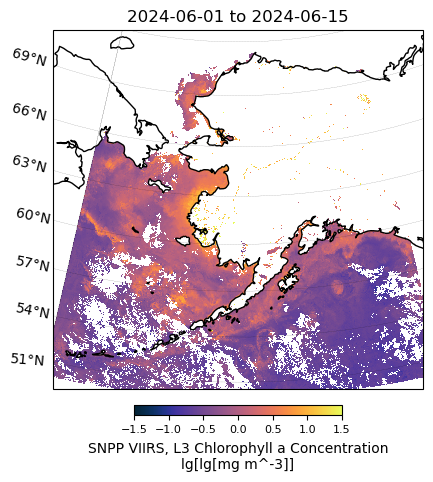

In [13]:
# Plot VIIRS data
m = regional_plot.plot_regional_map(viirs_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

[back to top](#Contents)

## 3. Download and process MODIS data

You may visit [NASA Earthdata Search](https://search.earthdata.nasa.gov/) and enter the short names to read about each data collection. We want to use the `MODISA_L3m_CHL` data collection for our plot. You can retrieve the files (granules) in that collection using `earthaccess.search_data()`.

In [17]:
tspan = ("2023-06-01", "2023-06-15")

# auth = earthaccess.login(persist=True)

# results = earthaccess.search_data(
#     short_name="MODISA_L3m_CHL",
#     granule_name="*.8D*.9km*",
#     temporal=tspan,
# )

# results[0]

By checking the first data, it indicates that the file is not cloud-hosted. We will need to download the data file with `earthaccess.download()`.

In [18]:
# paths = earthaccess.download(results, "../data/modis_chla")

In [19]:
paths = [
    '../data/modis_chla/AQUA_MODIS.20230525_20230601.L3m.8D.CHL.chlor_a.9km.nc',
    '../data/modis_chla/AQUA_MODIS.20230602_20230609.L3m.8D.CHL.chlor_a.9km.nc',
    '../data/modis_chla/AQUA_MODIS.20230610_20230617.L3m.8D.CHL.chlor_a.9km.nc'
]

In [20]:
modis_ds = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
modis_ds

<xarray.Dataset> Size: 112MB
Dimensions:  (date: 3, lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 9kB 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 112MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 2kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      AQUA_MODIS.20230525_20230601.L3m.8D.CH...
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    source:                            satellite observations from MODIS-Aqua
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2022
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3087431
    data_minimum:                      0.0031313652
    data_maximum:                      86.3219

Similar to previous steps, we calculate the log10 of the chlorophyll concentration, compute the 15-day average, and perform the reduction.

In [21]:
modis_chla = np.log10(modis_ds["chlor_a"])
modis_chla_mean = modis_chla.mean('date')
modis_chla_mean.attrs.update(
    {
        "long_name": f'MODIS {modis_ds["chlor_a"].attrs["long_name"]}',
        "units": f'log({modis_ds["chlor_a"].attrs["units"]})',
    }
)
modis_chla_mean_clip = modis_chla_mean.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

In [22]:
modis_chla_mean_clip

<xarray.DataArray 'chlor_a' (lat: 264, lon: 468)> Size: 494kB
dask.array<getitem, shape=(264, 468), dtype=float32, chunksize=(264, 468), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB 71.96 71.88 71.79 71.71 ... 50.21 50.12 50.04
  * lon      (lon) float32 2kB -179.0 -178.9 -178.8 ... -140.2 -140.1 -140.0
Attributes:
    long_name:  MODIS Chlorophyll Concentration, OCI Algorithm
    units:      log(mg m^-3)

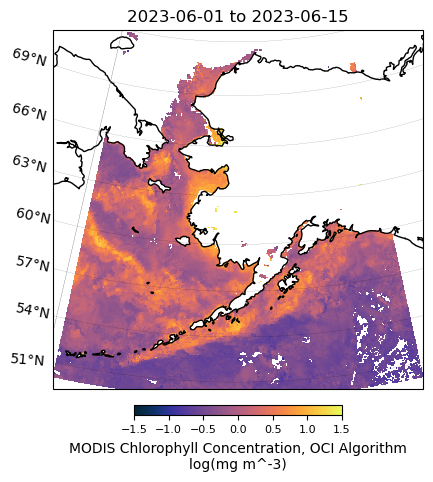

In [23]:
# Plot MODIS data
m = regional_plot.plot_regional_map(modis_chla_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(tspan[0],tspan[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

[back to top](#Contents)

## 4. Combine the plots side by side

In this step, we will generate a 2x2 figure with four subplots.

In [ ]:
# Calculate central longitude and latitude
central_longitude = (min_lon + max_lon) / 2
central_latitude = (min_lat + max_lat) / 2

# Define project
projection = ccrs.LambertConformal(central_longitude=central_longitude, 
                                   central_latitude=central_latitude)

fig, axs = plt.subplots(2, 2, figsize=(8, 10), 
                        subplot_kw={'projection': projection})

m1 = regional_plot.plot_regional_map(array_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[0, 0])

m2 = regional_plot.plot_regional_map(viirs_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[0, 1])

m3 = regional_plot.plot_regional_map(modis_chla_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(tspan[0],tspan[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[1, 0])

fig.tight_layout()

[back to top](#Contents)